# Differential expression analysis

## Install and import dependencies

In [ ]:
source("https://bioconductor.org/biocLite.R")
biocLite()

In [ ]:
biocLite(c("limma", "Glimma", "edgeR"))

In [121]:
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(scales)

In [4]:
getwd()

[1] "/Users/lvulliard/OneShotProject/RecArg1"

## Example analysis
https://www.bioconductor.org/help/workflows/RNAseq123/

In [5]:
biocLite("Mus.musculus")
library(Mus.musculus)

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.1 (2017-06-30).
Installing package(s) ‘Mus.musculus’
installing the source package ‘Mus.musculus’

Old packages: 'annotate', 'BH', 'bindr', 'biomaRt', 'blob', 'callr',
  'ChemmineR', 'd3heatmap', 'DBI', 'dbplyr', 'dendextend', 'devtools',
  'EBImage', 'ellipse', 'forcats', 'fpc', 'gdtools', 'GenomicFeatures',
  'GenomicRanges', 'git2r', 'GlobalOptions', 'haven', 'heatmaply', 'hexbin',
  'hms', 'httpuv', 'igraph', 'imageHTS', 'knitr', 'listviewer', 'lubridate',
  'MASS', 'matrixStats', 'MCPAN', 'mgcv', 'migest', 'mvtnorm', 'nlme',
  'officer', 'openssl', 'pcaPP', 'pillar', 'plogr', 'pryr', 'quantreg', 'Rcpp',
  'Rcssplot', 'RCurl', 'reprex', 'rgl', 'rlang', 'rmarkdown', 'RMySQL',
  'rpart', 'rtracklayer', 'rvg', 'selectr', 'seriation', 'shape',
  'shinydashboard', 'stringi', 'stringr', 'tibble', 'tidyr', 'tidyselect',
  'tikzDevice', 'viridis', 'viridisLite', 'withr', 'XML', 'xml2', 'yaml'
Loading

### Load input files

In [6]:
url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE63310&format=file"
utils::download.file(url, destfile="GSE63310_RAW.tar", mode="wb") 
utils::untar("GSE63310_RAW.tar", exdir = ".")
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", "GSM1545538_purep53.txt",
  "GSM1545539_JMS8-2.txt", "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt",
  "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", "GSM1545545_JMS9-P8c.txt")
for(i in paste(files, ".gz", sep=""))
  R.utils::gunzip(i, overwrite=TRUE)

In [7]:
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", 
   "GSM1545538_purep53.txt", "GSM1545539_JMS8-2.txt", 
   "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt", 
   "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", 
   "GSM1545545_JMS9-P8c.txt")
# Show data format
read.delim(files[1], nrow=5)

EntrezID,GeneLength,Count
497097,3634,1
100503874,3259,0
100038431,1634,0
19888,9747,0
20671,3130,1


In [8]:
# Directly construct matrix of gene count per condition
x <- readDGE(files, columns=c(1,3))
class(x)
dim(x)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

[1] 27179     9

In [9]:
# Input sample annotation
samplenames <- substring(colnames(x), 12, nchar(colnames(x)))
colnames(x) <- samplenames
group <- as.factor(c("LP", "ML", "Basal", "Basal", "ML", "LP", 
                     "Basal", "ML", "LP"))
x$samples$group <- group
lane <- as.factor(rep(c("L004","L006","L008"), c(3,4,2)))
x$samples$lane <- lane
x$samples

,files,group,lib.size,norm.factors,lane
10_6_5_11,GSM1545535_10_6_5_11.txt,LP,32863052,1,L004
9_6_5_11,GSM1545536_9_6_5_11.txt,ML,35335491,1,L004
purep53,GSM1545538_purep53.txt,Basal,57160817,1,L004
JMS8-2,GSM1545539_JMS8-2.txt,Basal,51368625,1,L006
JMS8-3,GSM1545540_JMS8-3.txt,ML,75795034,1,L006
JMS8-4,GSM1545541_JMS8-4.txt,LP,60517657,1,L006
JMS8-5,GSM1545542_JMS8-5.txt,Basal,55086324,1,L006
JMS9-P7c,GSM1545544_JMS9-P7c.txt,ML,21311068,1,L008
JMS9-P8c,GSM1545545_JMS9-P8c.txt,LP,19958838,1,L008


In [10]:
# Input gene annotation
geneid <- rownames(x)
genes <- select(Mus.musculus, keys=geneid, columns=c("SYMBOL", "TXCHROM"), 
                keytype="ENTREZID")
# Choose to keep only the first chromosome position of each gene
genes <- genes[!duplicated(genes$ENTREZID),]
head(genes)

x$genes <- genes

'select()' returned 1:many mapping between keys and columns


ENTREZID,SYMBOL,TXCHROM
497097,Xkr4,chr1
100503874,Gm19938,NA
100038431,Gm10568,NA
19888,Rp1,chr1
20671,Sox17,chr1
27395,Mrpl15,chr1


### Transform and filter data on abundance
CPM (counts per million) are just normalized by abundance in sample
Allows to compare between samples but not across genes (no normalization on gene length)

In [11]:
# head(10**6 * x$counts[,3] / colSums(x$counts)[3])
xCPM = cpm(x)
xLogCPM = cpm(x, log = T)
# NB: prior count of 0.25

In [12]:
table(rowSums(x$counts==0)==9)


FALSE  TRUE 
22026  5153 

In [13]:
keep.exprs <- rowSums(xCPM>1)>=3
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

[1] 14165     9

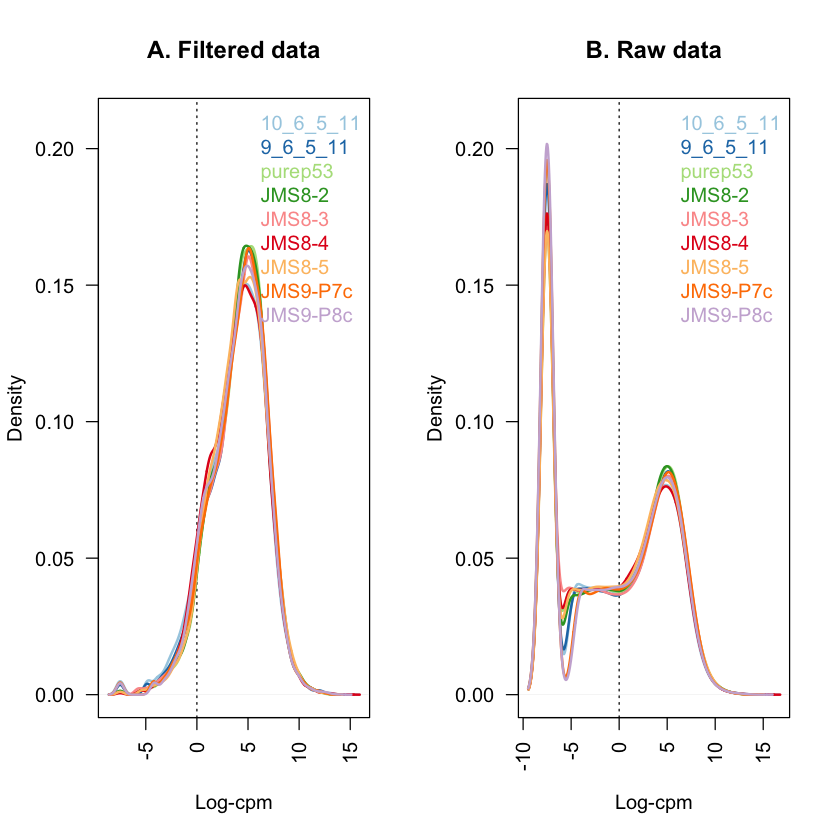

In [15]:
xLogCPMfiltered = cpm(x, log = T)

nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))



plot(density(xLogCPMfiltered[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="A. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
 den <- density(xLogCPMfiltered[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

plot(density(xLogCPM[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="B. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
   den <- density(xLogCPM[,i])
   lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

In [242]:
x <- calcNormFactors(x, method = "TMM")
x$samples

,files,group,lib.size,norm.factors,lane
10_6_5_11,GSM1545535_10_6_5_11.txt,LP,32832881,0.8957309,L004
9_6_5_11,GSM1545536_9_6_5_11.txt,ML,35296067,1.0349196,L004
purep53,GSM1545538_purep53.txt,Basal,57089259,1.0439552,L004
JMS8-2,GSM1545539_JMS8-2.txt,Basal,51304051,1.0405040,L006
JMS8-3,GSM1545540_JMS8-3.txt,ML,75724862,1.0323599,L006
JMS8-4,GSM1545541_JMS8-4.txt,LP,60457787,0.9223424,L006
JMS8-5,GSM1545542_JMS8-5.txt,Basal,55014064,0.9836603,L006
JMS9-P7c,GSM1545544_JMS9-P7c.txt,ML,21282257,1.0827381,L008
JMS9-P8c,GSM1545545_JMS9-P8c.txt,LP,19938942,0.9792607,L008


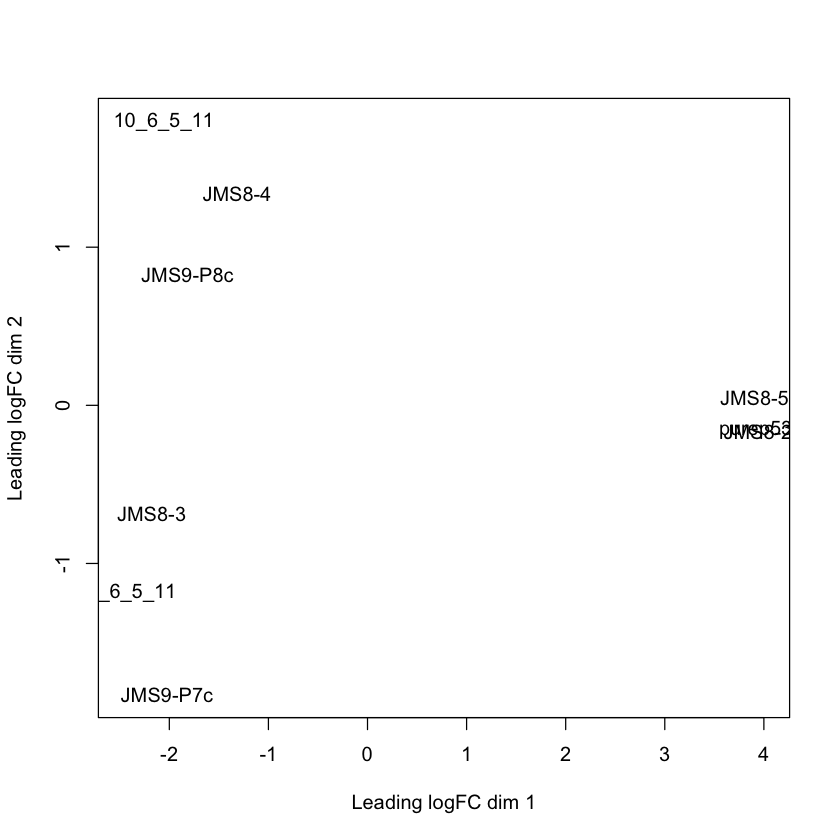

In [239]:
par(bg="white")
plotMDS(x) # Three distinct groups (LP/ML/Basal)

## RecArg1 effect analysis

In [216]:
# Load data (FPKM / gene / condition)
rnaData = read.csv("RNAseq.csv", sep = ";", dec = ",")
# Rename samples
colnames(rnaData) <- c("GeneID", paste(c("MCSF", "ArgFree", "ArgRescue", "RANKL", "ArgFreeRANKL", "ArgRescueRANKL", "RecArgRANKL"), 
      c(rep(1,7), rep(2,7), rep(3,7), rep(4,7)), sep="_"))

In [217]:
# Convert to DGE object
dgeData = DGEList(counts = rnaData[,2:29], genes = rnaData[1], group = rep(1:7, 4))

In [218]:
dim(dgeData)

[1] 24775    28

In [219]:
names(dgeData)

[1] "counts"  "samples" "genes"

In [220]:
# Input sample annotation
dgeData$samples$aMEM = rep(c(TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE),4)
dgeData$samples$aMEMwoLArg = rep(c(FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE),4)
dgeData$samples$LArg = rep(c(FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE),4)
dgeData$samples$recArg = rep(c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE),4)
dgeData$samples$RANKL = rep(c(FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE),4)
dgeData$samples$mouse = c(rep(1,7), rep(2,7), rep(3,7), rep(4,7))
dgeData$samples

,group,lib.size,norm.factors,aMEM,aMEMwoLArg,LArg,recArg,RANKL,mouse
MCSF_1,1,635939.8,1,TRUE,FALSE,FALSE,FALSE,FALSE,1
ArgFree_1,2,630525.3,1,FALSE,TRUE,FALSE,FALSE,FALSE,1
ArgRescue_1,3,644822.5,1,FALSE,TRUE,TRUE,FALSE,FALSE,1
RANKL_1,4,776441.0,1,TRUE,FALSE,FALSE,FALSE,TRUE,1
ArgFreeRANKL_1,5,758394.2,1,FALSE,TRUE,FALSE,FALSE,TRUE,1
ArgRescueRANKL_1,6,836530.3,1,FALSE,TRUE,TRUE,FALSE,TRUE,1
RecArgRANKL_1,7,717775.9,1,TRUE,FALSE,FALSE,TRUE,TRUE,1
MCSF_2,1,789636.5,1,TRUE,FALSE,FALSE,FALSE,FALSE,2
ArgFree_2,2,695793.6,1,FALSE,TRUE,FALSE,FALSE,FALSE,2
ArgRescue_2,3,703856.0,1,FALSE,TRUE,TRUE,FALSE,FALSE,2


In [221]:
table(rowSums(dgeData$counts==0)>=25)
table(rowSums(dgeData$counts==0)==28)


FALSE  TRUE 
18482  6293 


FALSE  TRUE 
20574  4201 

4201 genes are never expressed, 6293 are not expressed in more than 3 conditions, so not even in all replicates of a single condition.

In [222]:
dgeDataExpressed <- dgeData[rowSums(dgeData$counts==0)<25,, keep.lib.sizes=FALSE]
dim(dgeDataExpressed)

[1] 18482    28

Fpkm cannot be used to compare samples so we convert values to TPM
NB: TPM gives the proportion of transcripts in a sample, so one value depends on the others and comparing TPM values of one gene across samples does not make sense without taking into account the other values. On the other hand comparing full TPM profiles between samples seems coherent.

In [223]:
fpkmToTpm <- function(fpkm)
{
    exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
}

In [224]:
dgeDataExpressed = apply(dgeDataExpressed, 2, fpkmToTpm)

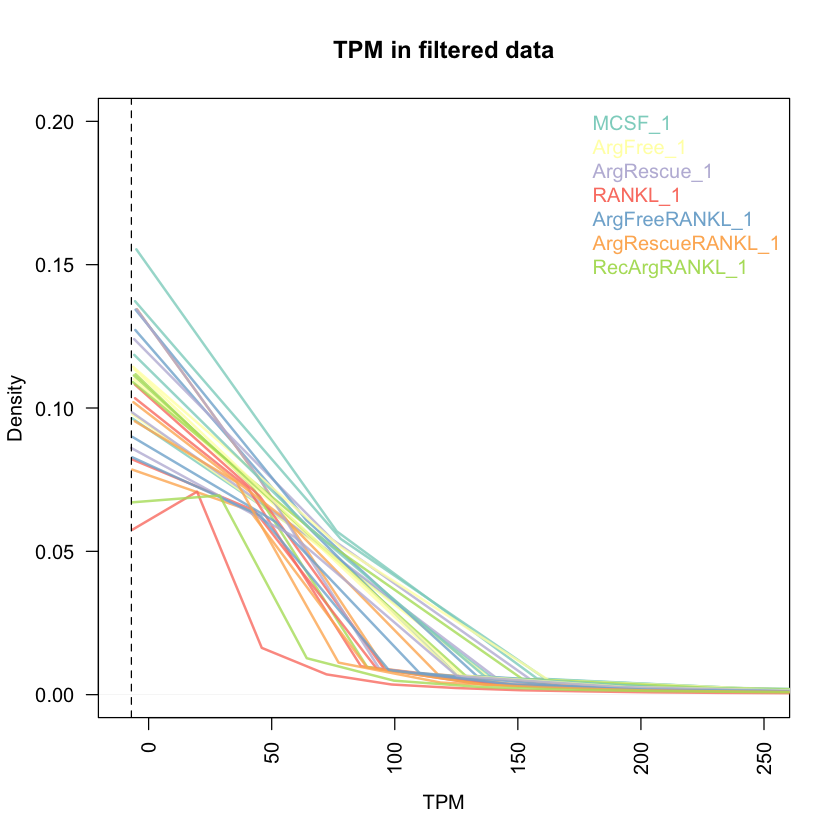

In [225]:
nsamples <- 28
col <- rep(brewer.pal(7, "Set3"), 4)
par(bg="white")

plot(density(dgeDataExpressed[,1]), col=alpha(col[1], 0.8), lwd=2, xlim = c(-10,250), ylim=c(0,0.2), las=2, 
     main="", xlab="")
title(main="TPM in filtered data", xlab="TPM")
for (i in 2:nsamples){
   den <- density(dgeDataExpressed[,i])
   lines(den$x, den$y, col=alpha(col[i], 0.8), lwd=2)
}
abline(v = -7, lty=2)
legend("topright", rownames(dgeData$samples)[1:7], text.col=col, bty="n")

Area under the curve should stay constant, since for every sample

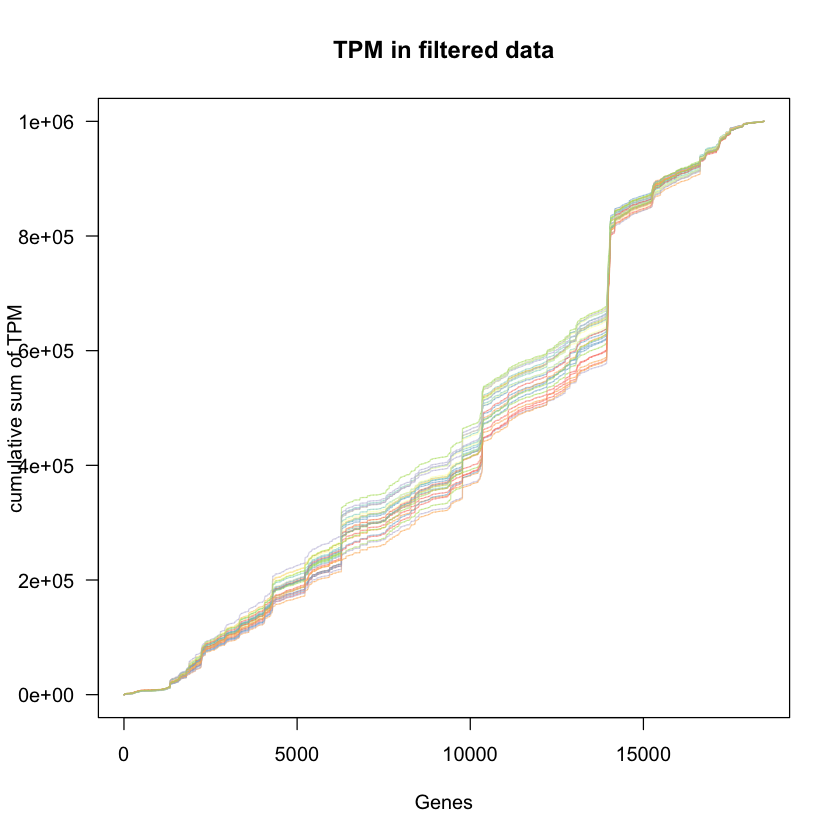

In [226]:
plot(cumsum(dgeDataExpressed[,1]), col=alpha(col[1], 0.5), lwd=1, ylim=c(0,1000000), las=1, 
     main="", xlab="", ylab = "", type = "l")
title(main="TPM in filtered data", xlab="Genes", ylab ="cumulative sum of TPM")
for (i in 2:nsamples){
   den <- cumsum(dgeDataExpressed[,i])
   lines(den, col=alpha(col[i], 0.5), lwd=1)
}
#legend("topright", rownames(dgeData$samples)[1:7], text.col=col, bty="n")

## TPM correlation between samples

In [227]:
library(d3heatmap)
d3heatmap(cor(dgeDataExpressed), theme = "dark")

HTML widgets cannot be represented in plain text (need html)

In [228]:
# Minimal correlation between replicates for each condition
sapply(1:7, function(x) min(cor(dgeDataExpressed[,x+0:3*7])))

[1] 0.7668644 0.7923737 0.7499311 0.7872368 0.6179538 0.7377636 0.6008874

In [229]:
# Minimal correlation between conditions for each replicate
sapply(1:4, function(x) min(cor(dgeDataExpressed[,7*(x-1) + 1:7])))

[1] 0.6713514 0.6929284 0.5197130 0.6976331

In [230]:
# Minimal overall correlation
min(cor(dgeDataExpressed))

[1] 0.519713

In [231]:
# Median correlation between replicates for each condition
sapply(1:7, function(x) median(cor(dgeDataExpressed[,x+0:3*7])))

[1] 0.8842903 0.9011861 0.8197909 0.9411752 0.8451230 0.8177929 0.8614758

In [232]:
# Median correlation between conditions for each replicate
sapply(1:4, function(x) median(cor(dgeDataExpressed[,7*(x-1) + 1:7])))

[1] 0.9408304 0.8377029 0.8819479 0.8545063

In [233]:
# Median overall correlation
median(cor(dgeDataExpressed))

[1] 0.8253051

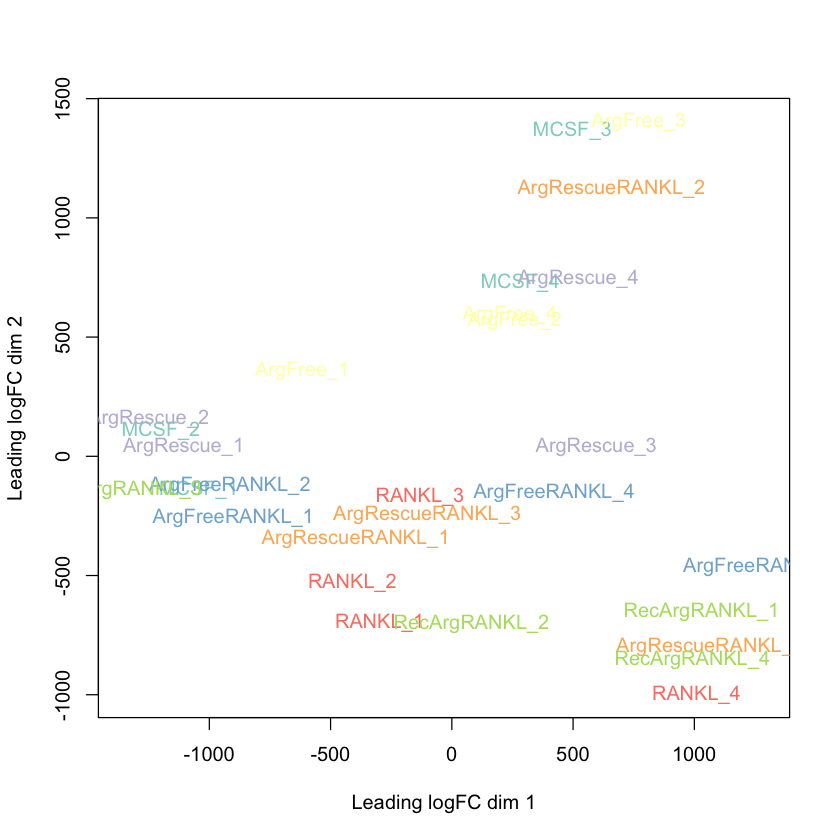

In [236]:
par(bg = "white")
plotMDS(dgeDataExpressed, col = col)

pdf 
  2

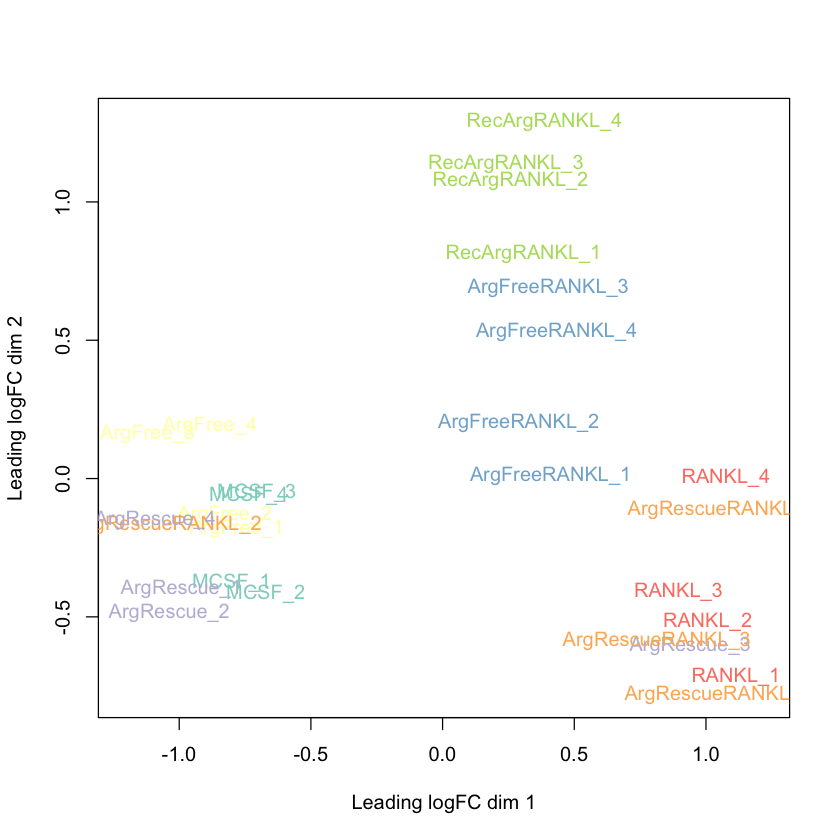

In [244]:
par(bg = "white")
plotMDS(dgeData, col = col)
png("mdsFPKM.png")
plotMDS(dgeData, col = col)
dev.off()

NB: (filtering + convertion to TPM) fucks things up